# Machine Learning Homework 4
#### Student: Liyan Xu

## 1. Kernel Methods

(a)
$$
\phi (x) = (\beta x_1^2, \beta x_2^2, \sqrt 2 \beta x_1 x_2, \sqrt{2\beta} x_1, \sqrt{2\beta} x_2)
$$
Verify that $k_{\beta} (x, z) = \phi (x) \phi (z)$:
$$
\begin{align}
&\phi (x) \cdot \phi (z)\\
&= (\beta x_1^2, \beta x_2^2, \sqrt 2 \beta x_1 x_2, \sqrt{2\beta} x_1, \sqrt{2\beta} x_2) \cdot (\beta z_1^2, \beta z_2^2, \sqrt 2 \beta z_1 z_2, \sqrt{2\beta} z_1, \sqrt{2\beta} z_2)\\
&= \beta^2 x_1^2 z_1^2 + \beta^2 x_2^2 z_2^2 + 2\beta^2 x_1 x_2 z_1 z_2 + 2\beta x_1 z_1 + 2\beta x_2 z_2\\
&= \beta^2 (x_1 z_1 + x_2 z_2)^2 + 2\beta (x_1 z_1 + x_2 z_2)\\
&= \beta^2 (x \cdot z) + 2\beta (x \cdot z) + 1 - 1\\
&= (1 + \beta x \cdot z)^2 - 1
\end{align}
$$

(b) Let $k_1 (x, z) = x^T z$. First use Scaling rule to obtain another kernel:
$$
k_2 (x, z) = \dfrac{1}{\Vert x \Vert} \dfrac{1}{\Vert z \Vert} k_1 (x, z) = (\dfrac{x}{\Vert x \Vert})^T (\dfrac{z}{\Vert z \Vert}) 
$$
Let $k_3$ be the constant kernel $k_3 (x, z) = 1$. Use Sum rule to obtain another kernel:
$$
k_4 (x, z) = k_2 (x, z) + k_3 (x, z) = 1 + (\dfrac{x}{\Vert x \Vert})^T (\dfrac{z}{\Vert z \Vert}) 
$$
Finally, use Product rule twice to get the target kernel:
$$
k(x, z) = k_4^3 (x, z) = (1 + (\dfrac{x}{\Vert x \Vert})^T (\dfrac{z}{\Vert z \Vert}))^3
$$

## 2. Pseudo-Random Forest to Predict Loan Defaults
#### We will be using the Loan Defaults dataset from Homework #3 loan default.csv. You will implement an adaptation of the random forest to detect loan defaults. Instead of randomly sampling features for each node of each tree in your forest, you will choose a random subspace (i.e., limit the attributes to consider) that the tree will be created on. This allows you to use existing decision trees without having to build your own.

#### (a) Build the adaptation of the random forest using your favorite language. You will want to make sure your forest supports the following parameters:
* **nest: the number of trees in the forest**
* **maxDepth: the maximum depth of each tree**
* **minSamplesLeaf: the minimum number of samples per leaf node**
* **q: the number of features for each tree**

#### In addition to predicting the output, your forest should be able to provide the out-of-bag (OOB) sample accuracy, and feature importance.

Read data and create training set and test set first; use same preprocessing from HW3.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read data
df = pd.read_csv("loan_default.csv", index_col=0)

# Fill out NA on emp_length feature with 5 years
df['emp_length'] = df['emp_length'].fillna('5 years')

# Encode ordinal features
df['term'] = df['term'].astype('category').cat.codes

df['grade'] = df['grade'].astype('category').cat.codes

df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['emp_length'] = df['emp_length'].astype('int64')

df['earliest_cr_line'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['earliest_cr_line'] = df['earliest_cr_line'].astype('int64')

dict_cat = {
    'verification_status': {
        'Not Verified': 0,
        'Source Verified': 1,
        'Verified': 2
    }
}
df.replace(dict_cat, inplace=True)

# Encode non-ordinal features
# Merge small and similar categories
dict_cat = {
    'purpose': {
        'wedding': 'vacation',
        'renewable_energy': 'other'
    }
}
df.replace(dict_cat, inplace=True)

df = pd.get_dummies(df, columns=["home_ownership"])
df = pd.get_dummies(df, columns=["purpose"])

In [3]:
# Get features and label after preparing data
y = df['class'].values
X = df.drop(columns='class').values
X_default = X    # Used later for Q4
y_default = y

In [10]:
# Define method to split data into training and test set
def split_training_test_set(X, y, test_ratio):
    idx_random = np.arange(y.shape[0])
    np.random.shuffle(idx_random)
    idx_split = int(test_ratio * y.shape[0])

    X_test = X[idx_random[:idx_split]]
    y_test = y[idx_random[:idx_split]]
    X_train = X[idx_random[idx_split:]]
    y_train = y[idx_random[idx_split:]]
    
    return X_train, y_train, X_test, y_test

In [241]:
# Split training and test set
test_ratio = 0.2

X_train, y_train, X_test, y_test = split_training_test_set(X, y, test_ratio)

print(X_train.shape)
print(X_test.shape)

(2280, 37)
(570, 37)


Define class of random forest. Use **AUC** as accuracy metric.

In [5]:
# Define class of random forest
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score

class RandomForestClassifier:
    def __init__(self, nest=25, max_depth=10, min_leaf=0.05, q=0.8):
        self.nest = nest
        self.max_depth = max_depth
        self.min_leaf = min_leaf
        self.q = q
        self.trees = None
    
    # Define training method, return OOB AUC and feature importance
    def train(self, X, y, nest=None, max_depth=None, min_leaf=None, q=None):
        self.trees = []
        oob_prob = [[] for i in range(y.size)]
        feature_importance = [[] for i in range(X.shape[1])]
        
        self.nest = nest if nest is not None else self.nest
        self.max_depth = max_depth if max_depth is not None else self.max_depth
        self.min_leaf = min_leaf if min_leaf is not None else self.min_leaf
        self.q = q if q is not None else self.q
        
        for b in range(self.nest):   
            idx_spl = resample(np.arange(y.shape[0]))
            X_spl = X[idx_spl]
            y_spl = y[idx_spl]
            
            dtc = DecisionTreeClassifier(max_depth=self.max_depth,
                                         min_samples_leaf=self.min_leaf,
                                         max_features=self.q)
            dtc.fit(X_spl, y_spl)
            self.trees.append(dtc)
            
            # Record OOB sample prediction (probability of positive label)
            idx_oob = np.setdiff1d(np.arange(y.shape[0]), idx_spl)
            X_oob = X[idx_oob]
            y_oob = y[idx_oob]
            y_oob_prob = dtc.predict_proba(X_oob)[:, 1]
            for i in range(idx_oob.size):
                oob_prob[idx_oob[i]].append(y_oob_prob[i])
            
            # Record feature importance
            accuracy = roc_auc_score(y_oob, y_oob_prob)
            for i in range(X_oob.shape[1]):
                X_oob_permuted = X_oob.copy()
                X_oob_permuted[:, i] = np.random.permutation(X_oob[:, i])
                accuracy_permuted = roc_auc_score(y_oob, dtc.predict_proba(X_oob_permuted)[:, 1])
                feature_importance[i].append(accuracy - accuracy_permuted)
        
        # Compute final OOB accuracy
        oob_prob_mean = []
        idx_ever_oob = []
        for i in range(y.size):
            if len(oob_prob[i]) != 0:
                idx_ever_oob.append(i)
                oob_prob_mean.append(np.array(oob_prob[i]).mean())
        
        accuracy_oob = roc_auc_score(y[idx_ever_oob], oob_prob_mean)
        
        # Compute final feature importance
        feature_importance_mean = np.array(feature_importance).mean(axis=1)
        
        return accuracy_oob, feature_importance_mean
    
    # Define prediction method: return predicted label, and probability of positive label
    def predict(self, X):
        pos_prob = []
        for i in range(len(self.trees)):
            pos_prob.append(self.trees[i].predict_proba(X)[:, 1])
        pos_prob_mean = np.array(pos_prob).mean(axis=0)
        return 1 * (pos_prob_mean > 0.5), pos_prob_mean

#### (b) For the number of trees (nest) in the range of 5-25, find the best parameters for the max depth, minimum sample leaf, and the number of features to consider for each tree. Justify your selection with supporting evidence (i.e., plots).

In [6]:
# define method to search parameters and plot AUC
import math
from mpl_toolkits.mplot3d import Axes3D

def search_rf_params(X, y, r_nest, r_max_depth, r_min_leaf, r_q):
    itr_nest = []
    idx_best = []
    for nest in r_nest:
        print('Processing nest = %d ...' % nest)
        itr_max_depth = []
        itr_min_leaf = []
        itr_q = []
        itr_auc = []
        itr_best = None
        itr_curr = 0
        for max_depth in r_max_depth:
            for min_leaf in r_min_leaf:
                for q in r_q:
                    rfc = RandomForestClassifier()
                    oob_auc, _ = rfc.train(X, y, nest, max_depth, min_leaf, q)
                    itr_max_depth.append(max_depth)
                    itr_min_leaf.append(min_leaf)
                    itr_q.append(q)
                    itr_auc.append(oob_auc)
                    
                    if itr_best is None or oob_auc > itr_auc[itr_best]:
                        itr_best = itr_curr
                    itr_curr += 1
                    
        itr_nest.append([itr_max_depth, itr_min_leaf, itr_q, itr_auc])
        idx_best.append(itr_best)
        print('when nest = %d, the best max_depth = %d, min_leaf = %.3f, q = %.1f, AUC = %.3f'
              % (nest, itr_max_depth[itr_best], itr_min_leaf[itr_best], itr_q[itr_best], itr_auc[itr_best]))
    
    # Plot AUC
    len_col = 3
    len_row = math.ceil(len(r_nest) / len_col)
    fig = plt.figure(figsize=(10, 18))
    for i in range(len(r_nest)):
        ax = fig.add_subplot(len_row, len_col, i+1, projection='3d')
        ax.scatter(itr_nest[i][0], itr_nest[i][1], itr_nest[i][2], c=itr_nest[i][3], cmap=plt.hot())
        ax.set_title('nest = %d' % r_nest[i])
        ax.set_xlabel('max_depth')
        ax.set_ylabel('min_leaf')
        ax.set_zlabel('q')
    plt.tight_layout()
    plt.show()
    
    return itr_nest, idx_best

In [128]:
# Define search range
r_nest = np.arange(5, 26, 2)
r_max_depth = np.arange(4, 21, 4)
r_min_leaf = np.linspace(0.01, 0.3, 6)
r_q = np.arange(0.5, 0.85, 0.1)

Processing nest = 5 ...
when nest = 5, the best max_depth = 8, min_leaf = 0.068, q = 0.8, AUC = 0.814
Processing nest = 7 ...
when nest = 7, the best max_depth = 16, min_leaf = 0.068, q = 0.7, AUC = 0.822
Processing nest = 9 ...
when nest = 9, the best max_depth = 12, min_leaf = 0.068, q = 0.8, AUC = 0.819
Processing nest = 11 ...
when nest = 11, the best max_depth = 4, min_leaf = 0.068, q = 0.8, AUC = 0.820
Processing nest = 13 ...
when nest = 13, the best max_depth = 12, min_leaf = 0.126, q = 0.7, AUC = 0.824
Processing nest = 15 ...
when nest = 15, the best max_depth = 8, min_leaf = 0.068, q = 0.8, AUC = 0.825
Processing nest = 17 ...
when nest = 17, the best max_depth = 8, min_leaf = 0.068, q = 0.8, AUC = 0.824
Processing nest = 19 ...
when nest = 19, the best max_depth = 8, min_leaf = 0.126, q = 0.6, AUC = 0.825
Processing nest = 21 ...
when nest = 21, the best max_depth = 12, min_leaf = 0.126, q = 0.7, AUC = 0.827
Processing nest = 23 ...
when nest = 23, the best max_depth = 16, 

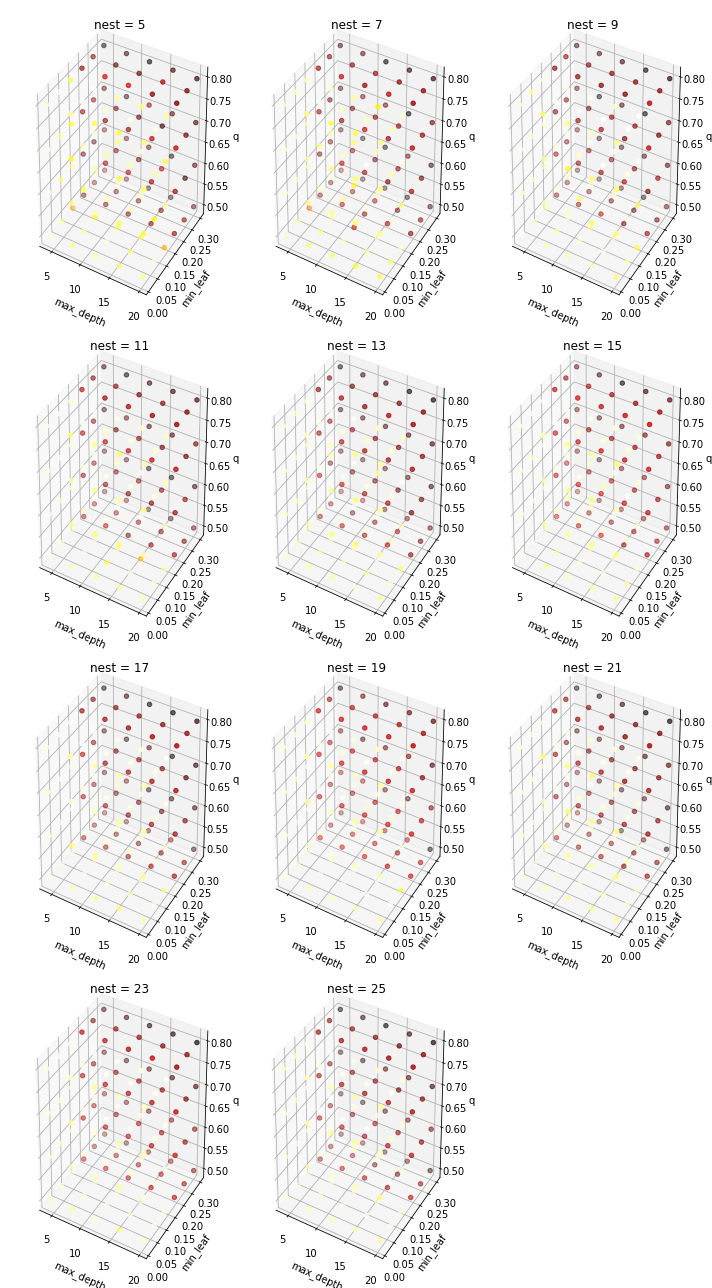

In [129]:
# Search parameters
itr_nest, idx_best = search_rf_params(X_train, y_train, r_nest, r_max_depth, r_min_leaf, r_q)

The best AUC is $0.828$, when nest = $25$, max_depth = $20$, min_leaf ratio = $0.068$, q ratio = $0.6$.

#### (c) Using your optimal parameters, how well does your version of the random forest perform on the test data? How does this compare to the OOB sample accuracy?

In [141]:
# Get best parameters
nest_opt_idx = 10
itr_bestparam = itr_nest[nest_opt_idx]
idx_bestparam = idx_best[nest_opt_idx]

nest_opt = r_nest[nest_opt_idx]
max_depth_opt = itr_bestparam[0][idx_bestparam]
min_leaf_opt = itr_bestparam[1][idx_bestparam]
q_opt = itr_bestparam[2][idx_bestparam]

In [157]:
# Train using best parameters
rfc = RandomForestClassifier()
auc_oob, feature_importance = rfc.train(X_train, y_train, nest_opt, max_depth_opt, min_leaf_opt, q_opt)

# Get AUC on test set
y_test_predicted, y_test_prob = rfc.predict(X_test)
auc_test = roc_auc_score(y_test, y_test_prob)
print('The AUC on OOB samples is %.3f' % auc_oob)
print('The AUC on test set is %.3f' % auc_test)

The AUC on OOB samples is 0.820
The AUC on test set is 0.825


Train the random forest with the best hyper-parameters,
* The AUC on OOB samples is $0.820$
* The AUC on test set is $0.825$

AUC on test set is slightly higher than that on OOB samples, but only with difference $0.005$. Overall the AUC on both OOB and test set are at the same level.

#### (d) What are the most important features from your model?

In [183]:
# Define method to plot feature importance
def plot_feature_importance(feature_importance, feature_name):
    idx_sorted = np.argsort(feature_importance)
    importance_sorted = feature_importance[idx_sorted]
    name_sorted = [feature_name[i] for i in idx_sorted]
    
    fig, ax = plt.subplots(figsize=(6, 8))
    ax.barh(np.arange(feature_importance.size), importance_sorted, tick_label=name_sorted)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

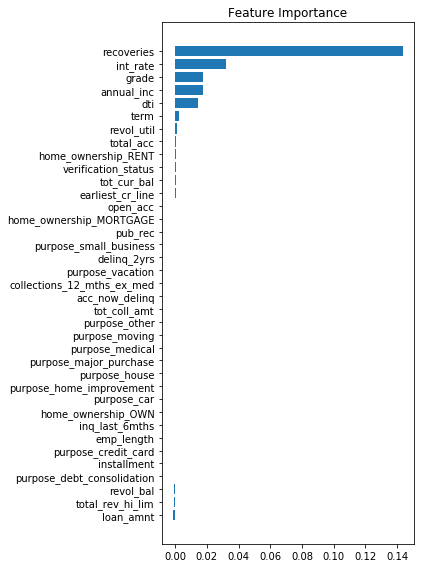

In [184]:
# Plot feature importance
feature_name = df.drop(columns='class').columns.tolist()
plot_feature_importance(feature_importance, feature_name)

From the plot, we can see:
* The most important feature is "recoveries", which can cause AUC to drop average $0.14$ by random permutation. This result coincides with the finding from HW3.
* Some other important features are: int_rate, grade, annual_inc, dti.

## 3. Spam Detection via Perceptron
#### We have provided a new e-mail spam dataset spamAssassin.data, which is a subset of the SpamAssassin Public Corpus (see https://spamassassin.apache.org/old/publiccorpus/).
#### We have already implemented the following email preprocessing steps: lower-casing; removal of HTML tags; normalization of URLs, e-mail addresses, and numbers. In addition, words have been reduced to their stemmed form. For example, “discount”, “discounts”, “discounted” and “discounting” are all replaced with “discount”. Finally, we removed all non-words and punctuation.
#### For this problem, you will implement the Perceptron algorithm and apply it to the problem of e-mail spam classification. You’ll be comparing two different variants of the algorithm as well as the number of epochs through the data.

#### (a) What is your model assessment strategy? Justify your validation methodology. (You may want to read the rest of this problem before you proceed to understand what your tasks will be).

* First split out data into training set and test set. The test set has 15% data because the feature space is quite large (more than $3000$), and there are only $6000$ samples.
* Use 10-fold cross-validation on training set, because of the large feature space and limited training samples.

#### (b) Build a vocabulary list using only the e-mail training set by finding all words that occur across the training set. Ignore all words that appear in fewer than 30 e-mails of the e-mail training set – this is both a means of preventing overfitting and of improving scalability. For each email, transform it into a feature vector x where the ith entry, xi, is 1 if the ith word in the vocabulary occurs in the email, and 0 otherwise.

In [4]:
# Read spam data from file
with open('spamAssassin.data') as f:
    lines = f.readlines()

In [5]:
# Define method to build vocabulary
def build_vocab(lines):
    vocab_appearance = {}
    for idx_line, line in enumerate(lines):
        tokens = line.split()
        for i in range(1, len(tokens)):
            token = tokens[i]
            if token not in vocab_appearance:
                vocab_appearance[token] = {idx_line}
            else:
                vocab_appearance[token].add(idx_line)

    # Take words that appear in >= 30 emails
    vocab_pos = {}
    pos_vocab = {}
    for word, appearance in vocab_appearance.items():
        if len(appearance) >= 30:
            vocab_pos[word] = len(vocab_pos)
            pos_vocab[vocab_pos[word]] = word
    
    return vocab_pos, pos_vocab

In [6]:
# Build vocabulary
vocab_pos, pos_vocab = build_vocab(lines)
pos_vocab[-1] = 'intercept'

In [7]:
# Define method to convert raw data to vector using vocabulary
def get_vectorized_data(lines, vocab_pos):
    X = np.zeros((len(lines), len(vocab_pos)))
    y = np.zeros(len(lines), dtype=int)
    for idx_line, line in enumerate(lines):
        tokens = line.split()
        if len(tokens) == 0:
            pass
        y[idx_line] = int(tokens[0])
        for i in range(1, len(tokens)):
            pos = vocab_pos.get(tokens[i], -1)
            if pos >= 0:
                X[idx_line, pos] = 1
    return X, y

In [8]:
# Get vectorized data
X, y = get_vectorized_data(lines, vocab_pos)
print(X.shape)
print(y.shape)

(6000, 3128)
(6000,)


In [11]:
# Split training and test set
test_ratio = 0.15

X_train, y_train, X_test, y_test = split_training_test_set(X, y, test_ratio)

print(X_train.shape)
print(X_test.shape)

(5100, 3128)
(900, 3128)


In [12]:
# Standardize and add bias term
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std = np.hstack((np.ones(y_train.size).reshape(-1, 1), X_train_std))
X_test_std = np.hstack((np.ones(y_test.size).reshape(-1, 1), X_test_std))

print(X_train_std.shape)
print(X_test_std.shape)

(5100, 3129)
(900, 3129)


#### (c) Implement the perceptron algorithm. You’ll want at least two functions:
* **Train the model that uses the examples provided to the function that returns the final classification vector, w, with the number of updates (mistakes) performed, and the number of passes (epochs) through the data. The algorithm will terminate either when all the points are correctly classified, or the max number of epochs have been reached. For the corner case of w · x = 0, predict the +1 class.**
* **Test new data given the classification vector w, and new data points. The function should return the test error.**

In [13]:
# Define Perceptron class
class Perceptron:
    def __init__(self, epoch=1e3, averaged=False):
        self.epoch = epoch
        self.averaged = averaged
        self.w = None
    
    def train(self, X, y, epoch=None, averaged=None):
        self.epoch = epoch if epoch is not None else self.epoch
        self.averaged = averaged if averaged is not None else self.averaged
        self.w = np.random.rand(X.shape[1])
        epoch = 0
        n_mistakes = 0
        if self.averaged:
            w_sum = self.w.copy()
        
        for epoch in range(1, self.epoch + 1):
            n_curr_mistakes = 0
            idx_shuffle = np.random.permutation(y.size)
            for i in idx_shuffle:
                y_predicted = 1 if X[i] @ self.w >= 0 else 0
                if y_predicted != y[i]:
                    n_curr_mistakes += 1
                    if y[i] == 1:
                        self.w += X[i]
                    else:
                        self.w -= X[i]
                
                if self.averaged:
                    w_sum += self.w
                    
            if n_curr_mistakes == 0:
                break
            n_mistakes += n_curr_mistakes
            
        if self.averaged:
            self.w = w_sum / epoch
        
        return n_mistakes, epoch
    
    def predict(self, X):
        return 1 * (X @ self.w >= 0)
    
    # Define method to return misclassification rate
    def error(self, X, y):
        y_predicted = self.predict(X)
        return np.sum(y_predicted != y) / y.size

#### (d) Train the perceptron using your training set. Plot the training and estimated generalization error as a function of the maximum number of epochs. What is the optimal algorithm and parameter? How many mistakes are made before the algorithm terminates if you wanted to classify all the training points properly?

In [14]:
# Define method to search parameter (epochs) by k-fold and plot misclassification error
from sklearn.model_selection import KFold

def search_perceptron_params(X, y, r_epoch, averaged, K):
    itr_epoch = []
    itr_mistake = []
    itr_err_training = []
    itr_err_valid = []
    idx_best = None
    idx_curr = 0
    
    for epoch in r_epoch:
        print('Processing epoch = %d' % epoch)
        kf = KFold(n_splits=K)
        errs_training = []
        errs_valid = []
        mistakes = []
        epochs_actual = []
        for idx_train, idx_valid in kf.split(X):
            X_train = X[idx_train]
            y_train = y[idx_train]
            X_valid = X[idx_valid]
            y_valid = y[idx_valid]
            
            pct = Perceptron(epoch=epoch, averaged=averaged)
            mistake, epoch_actual = pct.train(X_train, y_train)
            mistakes.append(mistake)
            epochs_actual.append(epoch_actual)
            errs_training.append(pct.error(X_train, y_train))
            errs_valid.append(pct.error(X_valid, y_valid))
        
        itr_mistake.append(np.array(mistakes).mean())
        itr_err_training.append(np.array(errs_training).mean())
        itr_err_valid.append(np.array(errs_valid).mean())
        itr_epoch.append(epoch)
        
        print('Average mistakes are %.2f, average actual epoch is %.2f, validation error is %.3f' %
              (itr_mistake[-1], np.array(epochs_actual).mean(), itr_err_valid[-1]))
        
        if idx_best is None or itr_err_valid[-1] < itr_err_valid[idx_best]:
            idx_best = idx_curr
        idx_curr += 1
    
    print('The best epoch is %d, where validation error is %.3f' %
          (itr_epoch[idx_best], itr_err_valid[idx_best]))
    
    # Plot error
    ax = plt.gca()
    ax.plot(itr_epoch, itr_err_training, label='training')
    ax.plot(itr_epoch, itr_err_valid, label='validation')
    plt.xlabel('Max Epoch')
    plt.ylabel('Misclassification Rate')
    ax.legend()
    plt.show()
    
    return itr_epoch, itr_mistake, itr_err_training, itr_err_valid, idx_best

Processing epoch = 1
Average mistakes are 362.70, average actual epoch is 1.00, validation error is 0.044
Processing epoch = 4
Average mistakes are 500.40, average actual epoch is 4.00, validation error is 0.029
Processing epoch = 7
Average mistakes are 520.40, average actual epoch is 7.00, validation error is 0.026
Processing epoch = 10
Average mistakes are 532.10, average actual epoch is 9.60, validation error is 0.028
Processing epoch = 13
Average mistakes are 535.90, average actual epoch is 11.70, validation error is 0.027
Processing epoch = 16
Average mistakes are 542.10, average actual epoch is 13.40, validation error is 0.028
Processing epoch = 19
Average mistakes are 553.50, average actual epoch is 15.20, validation error is 0.024
Processing epoch = 22
Average mistakes are 551.40, average actual epoch is 15.50, validation error is 0.028
Processing epoch = 25
Average mistakes are 545.30, average actual epoch is 15.00, validation error is 0.028
Processing epoch = 28
Average mista

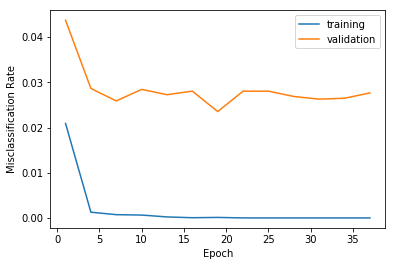

In [295]:
# Search parameter epoch and plot error
r_epoch = np.arange(1, 40, 3)
itr_epoch, itr_mistake, _, itr_err_valid, idx_best = search_perceptron_params(X_train_std, y_train, r_epoch, False, 10)

From above we can see:
* After around $15$ epochs, all training samples are all correctly classified, and the average mistakes to take to classify all training samples correctly are around $550$.
* The max_epoch that achieves the lowest validation error $0.024$ is $19$. However, since the actual number of epochs is around $15$, and Perceptron's training has randomness, this shouldn't be taken directly as the best parameter.
* The best algorithm for this problem is to wait till most (but not all) training samples correctly classified, and to stop early slightly before all training samples are correctly classified. Because based on the plot, validation error generally gets decreased when training error decreases, but stops decreasing after overfitting. The best parameter (max_epoch) can be $7$ when validation error is very close to min, and not completely overfitting.

#### (e) Implement the averaged perceptron algorithm, which is the same as your current implementation but which, rather than returning the final weight vector, returns the average of all weight vectors considered during the algorithm (including examples where no mistake was made). Averaging reduces the variance between the different vectors, and is a powerful means of preventing the learning algorithm from overfitting (serving as a type of regularization). Plot the training and estimated generalization error as a function of the maximum number of epochs for the averaged perceptron.

Implementation is included in Perceptron class.

Processing epoch = 1
Average mistakes are 356.80, average actual epoch is 1.00, validation error is 0.035
Processing epoch = 4
Average mistakes are 498.60, average actual epoch is 4.00, validation error is 0.029
Processing epoch = 7
Average mistakes are 518.80, average actual epoch is 7.00, validation error is 0.025
Processing epoch = 10
Average mistakes are 536.70, average actual epoch is 9.90, validation error is 0.023
Processing epoch = 13
Average mistakes are 540.40, average actual epoch is 12.50, validation error is 0.023
Processing epoch = 16
Average mistakes are 548.90, average actual epoch is 14.10, validation error is 0.024
Processing epoch = 19
Average mistakes are 537.10, average actual epoch is 15.20, validation error is 0.025
Processing epoch = 22
Average mistakes are 548.10, average actual epoch is 16.00, validation error is 0.028
Processing epoch = 25
Average mistakes are 542.50, average actual epoch is 13.00, validation error is 0.025
Processing epoch = 28
Average mista

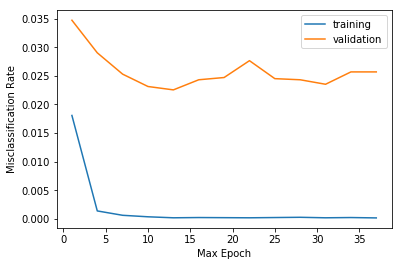

In [310]:
# Search parameter epoch and plot error
r_epoch = np.arange(1, 40, 3)
itr_epoch, itr_mistake, _, itr_err_valid, idx_best = search_perceptron_params(X_train_std, y_train, r_epoch, True, 10)

From above we can see:
* After around $14$ epochs, all training samples are all correctly classified, and the average mistakes to take to classify all training samples correctly are around $550$.
* The best parameter max_epoch is $10$ (or $13$), where validation error around $0.023$ is the lowest, and not completely overfitting (training error is not 0).
* Averaging weights helps to reduce the variance, as we can see that the validation error is overall slightly lower than that of not averaging weights.

#### (f) What is your final or “optimal” algorithm? In other words, train the model with as much data as you can possibly with the optimal algorithm + hyperparameter (maximum number of epochs) values. What is the expected predictive performance of this model?

Based on the observation from (d) and (e), use the averaging-weight Perceptron with max_epoch $10$, so that it has validation error close to min and is not completely overfitting.

In [16]:
pct = Perceptron(epoch=10, averaged=True)
n_mistake, epoch_actual = pct.train(X_train_std, y_train)
err_test = pct.error(X_test_std, y_test)
print('The expected predictive performance on test set is %.3f' % (1-err_test))

The expected predictive performance on test set is 0.971


#### (g) Using the vocabulary list together with the parameters learned in the previous question, output the 15 words with the most positive weights. What are they? Which 15 words have the most negative weights?

In [333]:
# Print 15 words with most positive weights
idx_sorted = np.argsort(pct.w)
idx_top15 = idx_sorted[:-16:-1]
print('15 words that have most positive weights:')
for i in idx_top15:
    print('%s\t%.3f' % (pos_vocab[i-1], pct.w[i]))  # remove w intercept

15 words that have most positive weights:
click	575400.807
remov	516828.521
our	409523.265
nbsp	393563.616
sight	393372.637
deathtospamdeathtospamdeathtospam	359628.016
guarante	348034.063
here	346093.537
your	331465.931
enumb	318094.071
offer	294564.152
within	290290.584
amp	290146.954
market	280576.681
below	277226.455


In [341]:
# Print 15 words with most negative weights
idx_top15 = idx_sorted[:15]
print('15 words that have most negative weights:')
for i in idx_top15:
    print('%s\t%.3f' % (pos_vocab[i-1], pct.w[i]))  # remove w intercept

15 words that have most negative weights:
intercept	-1547883.655
i	-393104.373
marri	-370735.203
remind	-369268.075
vital	-336923.415
url	-330499.482
sp	-315032.765
zone	-309576.899
it	-305630.619
numbertnumb	-288937.015
httpaddr	-285130.249
scale	-279469.215
team	-271846.796
polic	-263652.890
two	-262470.794


## 4. Loan Default Prediction with SVM
#### We will be using the loan dataset and evaluating the model on AUC, F1 score, and F2 score. Note that SVM with polynomial and RBF kernels can be quite expensive – you might want to use a beefier machine to do this.

#### (a) Why would you potentially be interested in optimizing for F2 score compared to F1 score in the context of finding individuals that are likely to default?

F2 score is more sentitive to Recall, compared to F1. For this problem, F2 is a better metric because we care more about recalling all positive (default) cases; while it doesn't hurt much to have lower precision.

#### (b) Train a linear SVM. How did you find the optimal parameter (C)?

* Use grid search with 5-fold CV on training set to find the best parameter C.
* Use F2 score as evaluation metric.

In [7]:
# Prepare training and test set
X = X_default
y = y_default
test_ratio = 0.2

X_train, y_train, X_test, y_test = split_training_test_set(X, y, test_ratio)

print(X_train.shape)
print(X_test.shape)

(2280, 37)
(570, 37)


In [10]:
# Standardize data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [67]:
# Define F2 scorer
from sklearn.svm import SVC
from sklearn.metrics import f1_score, fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

f2_scorer = make_scorer(fbeta_score, beta=2)

In [72]:
# Grid search parameter C by 5-fold CV
r_c = [0.5, 1, 5, 10, 15, 20]
grid = GridSearchCV(SVC(kernel='linear', probability=True), param_grid={'C': r_c}, scoring=f2_scorer, cv=5, n_jobs=4)
grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'C': [0.5, 1, 5, 10, 15, 20]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=2), verbose=0)

In [73]:
# Get best estimator and parameter
svc_linear = grid.best_estimator_
c_linear = grid.best_params_['C']
score_linear = grid.best_score_
print('For linear kernel, the best C = %.3f and mean validation F2 score is %.3f' % (c_linear, score_linear))

For linear kernel, the best C = 10.000 and mean validation F2 score is 0.488


#### (c) Train a polynomial kernel where the parameter values are chosen using Grid Search cross-validation (hint: think about using GridSearchCV in sklearn).

Use degree $=3$.

In [74]:
# Grid search parameter C by 5-fold CV
r_c = np.arange(200, 3000, 200)
grid = GridSearchCV(SVC(kernel='poly', degree=3, probability=True), param_grid={'C': r_c}, scoring=f2_scorer, cv=5, n_jobs=4)
grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'C': array([ 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000, 2200,
       2400, 2600, 2800])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=2), verbose=0)

In [75]:
# Get best estimator and parameter
svc_poly = grid.best_estimator_
c_poly = grid.best_params_['C']
score_poly = grid.best_score_
print('For polynomial kernel, the best C = %.3f and mean validation F2 score is %.3f' % (c_poly, score_poly))

For polynomial kernel, the best C = 1000.000 and mean validation F2 score is 0.526


#### (d) Train a polynomial kernel where the parameter values are chosen using Random Search cross-validation (hint: think about using RandomizedSearchCV in sklearn) with 1/4 of the total number of parameter settings of the previous part. For example, if GridSearch tries 12 different settings in total, RandomizedSearch would try 3. How does the parameters from GridSearch and RandomizedSearch perform on the test dataset? Comment on the trade-off between computational run-time and the predictive performance of the model between the two cross-validation techniques.

In [76]:
# Grid search parameter C by 5-fold CV
r_c = np.arange(200, 3000, 200)
rdcv = RandomizedSearchCV(SVC(kernel='poly', degree=3, probability=True), param_distributions={'C': r_c},
                          scoring=f2_scorer, cv=5, n_jobs=4, n_iter=r_c.size//4)
rdcv.fit(X_train_std, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=3, n_jobs=4,
          param_distributions={'C': array([ 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000, 2200,
       2400, 2600, 2800])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=2), verbose=0)

In [77]:
# Get best estimator and parameter
svc_poly_rs = rdcv.best_estimator_
c_poly_rs = rdcv.best_params_['C']
score_poly_rs = rdcv.best_score_
print('For polynomial kernel with random search, the best C = %.3f and mean validation F2 score is %.3f' %
      (c_poly_rs, score_poly_rs))

For polynomial kernel with random search, the best C = 600.000 and mean validation F2 score is 0.525


In [78]:
# Get F2 score on test set
f2_test_grid = fbeta_score(y_test, svc_poly.predict(X_test_std), beta=2)
f2_test_rs = fbeta_score(y_test, svc_poly_rs.predict(X_test_std), beta=2)
print('F2 score on test set from grid-search SVC: %.3f' % f2_test_grid)
print('F2 score on test set from randomized-search SVC: %.3f' % f2_test_rs)

F2 score on test set from grid-search SVC: 0.553
F2 score on test set from randomized-search SVC: 0.526


Observation:
* The performance has negligible difference; both models achieve similar F2 score on validation set (around $0.525$) and test set (around $0.554$).
* Grid Search tries every possible choice of given parameters, therefore the result is usually good. However, it requires a lot of computational resource if search space is large.
* Randomized Search can have less computation by limiting the iteration times; while it doesn't guarantee the chosen parameters always achieve lowest validation error; the result might not be as good as Grid Search.

#### (e) Build an RBF-kernel SVM. How did you choose the optimal parameter(s) for your model?

* Use grid search with 5-fold CV on training set to find the best parameter C.
* Use F2 score as evaluation metric.

In [93]:
# Grid search parameter C by 5-fold CV
r_c = np.arange(200, 3000, 200)
grid = GridSearchCV(SVC(kernel='rbf', probability=True), param_grid={'C': r_c}, scoring=f2_scorer, cv=5, n_jobs=4)
grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'C': array([ 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000, 2200,
       2400, 2600, 2800])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=2), verbose=0)

In [94]:
# Get best estimator and parameter
svc_rbf = grid.best_estimator_
c_rbf = grid.best_params_['C']
score_rbf = grid.best_score_
print('For rbf kernel, the best C = %.3f and mean validation F2 score is %.3f' % (c_rbf, score_rbf))

For rbf kernel, the best C = 600.000 and mean validation F2 score is 0.525


#### (f) Report the evaluation metrics for the training and test set for all of the above. How do they (the 4 SVM models) compare in terms of the 3 different metrics? How does it compare against the decision tree, bootstrap aggregating of linear models (problem 3 of homework 3), and the pseudo random forest from problem 2 in terms of computation time, predictive accuracy, and ease of interpretation of the resulting model?

In [91]:
# Define method to compute AUC, F1, F2 scores on training and test set
def compute_scores(models, X_train, y_train, X_test, y_test):
    auc_train = []
    auc_test = []
    f1_train = []
    f1_test = []
    f2_train = []
    f2_test = []
    
    for model in models:
        auc_train.append(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
        auc_test.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
        y_train_predicted = model.predict(X_train)
        y_test_predicted = model.predict(X_test)
        f1_train.append(f1_score(y_train, y_train_predicted))
        f1_test.append(f1_score(y_test, y_test_predicted))
        f2_train.append(fbeta_score(y_train, y_train_predicted, beta=2))
        f2_test.append(fbeta_score(y_test, y_test_predicted, beta=2))
    return [auc_train, auc_test, f1_train, f1_test, f2_train, f2_test]

In [95]:
# Show scores
scores = compute_scores([svc_linear, svc_poly, svc_poly_rs, svc_rbf], X_train_std, y_train, X_test_std, y_test)
scores = pd.DataFrame(scores,
                      ['AUC Train', 'AUC Test', 'F1 Train', 'F1 Test', 'F2 Train', 'F2 Test'],
                      ['Linear', 'Poly By Grid', 'Poly By Random', 'RBF'])
scores

,Linear,Poly By Grid,Poly By Random,RBF
AUC Train,0.741556,0.999994,0.999225,1.000000
AUC Test,0.779357,0.709789,0.706088,0.766552
F1 Train,0.605025,0.997114,0.988372,1.000000
F1 Test,0.607143,0.512676,0.492837,0.539185
F2 Train,0.489113,0.996251,0.983227,1.000000
F2 Test,0.491329,0.552855,0.526316,0.546379


Comparison between 4 models: (since we are optimizing F2 score, I will focus on F2 as main evaluation metric)
* Linear model has the worst performance according to F2 score on test set.
* Two polynomial models have similar performance on all metrics (AUC, F1, F2); the randomized-search model has slightly lower performance ($0.025$ lower on F2 Test) than the grid-search model.
* RBF model overall has similar performance with the two polynomial models. It shows stronger tendency to overfit, as all metrics on training set have score $1$. The F2 score on test (around $0.55$) is very close to the grid-search poly model.
* Only the linear model has similar scores on both training and test set, which shows underfitting. Two polynomial models and RBF model shows overfitting, with very high scores on training set but much lower scores on test set.

Comparison with decision tree:
* Decision tree has AUC $0.8$ on test set.
* All 4 SVC models have AUC in $(0.7, 0.78)$, which is descent but lower than that of decision tree. However, it doesn't mean SVC has worse performance, because we are optimizing F2 in this problem.
* Decision tree has less computational time, while SVC is computationally heavy.
* Decision tree is easy to interpret, while SVC is harder to get feature importance.

Comparison with bootstrap aggregating of linear models:
* Bootstrap aggregating of linear models has AUC $0.836$ on test set.
* Performance pespective, same as above: 4 SVC models have descent but lower AUC; it doesn't mean SVC has worse performance.
* Bootstrap aggregating of linear models generally has less computational time than SVC, but it depends on the number of linear models. If the number is too large, computation could surpass SVC.
* Bootstrap aggregating of linear models is not easy to interpret, but is still possible by aggregating weights; still easier than SVC.

Comparison with pseudo random forest:
* Pseudo random forest has AUC $0.825$ on test set.
* Performance pespective, same as above.
* Pseudo random forest generally has less computational time than SVC, but it also depends on the number of trees.
* Pseudo random forest is not hard to interpret, as we have already done in Q2. SVC is hard to interpret.